In [1]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
print('Imported')
### not even sure if i used all of these, oh well ###

Imported


In [2]:
### Last Refresh ###

baseurl='https://www.arenamate.net/?faction=&ladder=RBG'
data = requests.get(baseurl).text 
soup = BeautifulSoup(data,"html5lib")
#print(soup.prettify())

refresh_ladder=soup.find('abbr')
print('Ladder Refreshed:')
print(refresh_ladder)
print(' ')

baseurl='https://www.arenamate.net/arena-rbg-title-cutoffs'
data = requests.get(baseurl).text 
soup = BeautifulSoup(data,"html5lib")
#print(soup.prettify())

refresh_cutoff=soup.find_all('abbr')
print('Title Cutoff Refreshed:')
print(refresh_cutoff[1])

Ladder Refreshed:
<abbr data-livestamp="2021-03-29T22:08:03.000-07:00" title="Mar 29, 2021 - 10:08 PM (America/LA)">Mar 29, 2021 - 10:08 PM (America/LA)</abbr>
 
Title Cutoff Refreshed:
<abbr data-livestamp="2021-03-29T07:39:17.000-07:00" title="Mar 29, 2021 - 07:39 AM (America/LA)">Mar 29, 2021 - 07:39 AM (America/LA)</abbr>


In [3]:
### long runtime - go get a snack ###

### Building Leaderboard Table ###

baseurl='https://www.arenamate.net/?faction=&ladder=RBG'

columns = []
all_rows = []
    
for page in range(1,101):
    new_url=str(baseurl) + '&page=' + str(page) + '&rating=0&realm=&region=US'
    data = requests.get(new_url).text 
    soup = BeautifulSoup(data,"html5lib")
    rating_table = soup.find("table", attrs={"id": "results-table"})
    
    body=rating_table.find_all('tr')
    head = body[0] 
    body_rows = body[1:]
        
    for item in rating_table.find_all("th"): 
        if page > 1:
            break
        else:
            item = (item.text).rstrip("\n")
            columns.append(item)
        
    for row_num in range(len(body_rows)):
        row=[]
        for row_item in body_rows[row_num].find_all("td"):
            aa = re.sub("(\xa0)|(\n)|,","",row_item.text)
            row.append(aa)
            all_rows.append(row)
            
print('Data Loaded')

Data Loaded


In [4]:
df = pd.DataFrame(data=all_rows, columns=columns)
df_collected=df.drop_duplicates(keep='first', inplace=False)
df_total=df_collected.rename(columns={'Details/Name':'GamerTag','Played/W/L/Win % (SL S1)':'P/W/L/%'})
df_total

,Rank,Rating,Follow,GamerTag,Realm,P/W/L/%
0,1 1,3064,,Suspex,Bleeding Hollow,229 198 31 87.0%
6,2 2,3036,,Slipnslide,Mal'Ganis,160 120 40 75.0%
12,3 2,3036,,Spanksv,Tichondrius,157 118 39 75.0%
18,4 4,3026,,Vinnythepope,Bleeding Hollow,164 123 41 75.0%
24,5 5,3019,,Factszxy,Area 52,223 187 36 84.0%
...,...,...,...,...,...,...
29898,4984 4994,2227,,Vicous,Kil'jaeden,138 87 51 63.0%
29904,4985 4994,2227,,Woollygeezer,Illidan,93 53 40 57.0%
29910,4986 4994,2227,,Yossh,Illidan,101 63 38 62.0%
29916,4987 4994,2227,,Zimzer,Area 52,102 65 37 64.0%


In [5]:
### Player Win/Lose Statistics ###

df_play_stat=df_total[['GamerTag','Rating','P/W/L/%']]
df_play_stat.reset_index(inplace=True)
df_play_stat.drop('index', axis=1, inplace=True)
df_stats_num=df_play_stat.Rating.astype('int64')
#print(df_stats_num.dtypes)


split = df_play_stat['P/W/L/%'].str.split(' ',expand = True)
#print(split)
d = {'Plays':split[2],'Wins':split[3],'Loses':split[4]}
df_stats = pd.DataFrame(data=d)
df_stat_int=df_stats.astype('int64')
#print(df_stat_int.dtypes)
df_stat_int

percent=[]
win_lose=[]
for games in df_stat_int:
    player_percent=(df_stat_int['Wins']/df_stat_int['Plays'])*100
    player_win_lose=(df_stat_int['Wins']/df_stat_int['Loses'])
    percent.append(player_percent)
    win_lose.append(player_win_lose)
#print(percent)    
df_raw=pd.DataFrame(percent)  
df_percent=df_raw.drop_duplicates(keep='first',inplace=False)
df_tperc=df_percent.transpose()
df_tperc.columns =['WinPercent']
df_P=df_tperc.astype('float')
df_P

df_raw_wl=pd.DataFrame(win_lose)  
df_wl=df_raw_wl.drop_duplicates(keep='first',inplace=False)
df_twl=df_wl.transpose()
df_twl.columns =['Win/Lose']
df_WL=df_twl.astype('float')
df_WL

df_total_stats=pd.concat([df_stat_int, df_P, df_WL], axis=1)
df_total_stats

df_player_stats=pd.concat([df_play_stat['GamerTag'],df_stats_num, df_total_stats], axis=1)
df_player_stats.round(2)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,GamerTag,Rating,Plays,Wins,Loses,WinPercent,Win/Lose
0,Suspex,3064,229,198,31,86.46,6.39
1,Slipnslide,3036,160,120,40,75.00,3.00
2,Spanksv,3036,157,118,39,75.16,3.03
3,Vinnythepope,3026,164,123,41,75.00,3.00
4,Factszxy,3019,223,187,36,83.86,5.19
...,...,...,...,...,...,...,...
4983,Vicous,2227,138,87,51,63.04,1.71
4984,Woollygeezer,2227,93,53,40,56.99,1.32
4985,Yossh,2227,101,63,38,62.38,1.66
4986,Zimzer,2227,102,65,37,63.73,1.76


,Rating,Plays,Wins,Loses,WinPercent,Win/Lose
Rating,1.000000,0.073479,0.177449,-0.069580,0.481330,0.466513
Plays,0.073479,1.000000,0.974028,0.954325,-0.190561,-0.104322
Wins,0.177449,0.974028,1.000000,0.861889,-0.001765,0.067339
Loses,-0.069580,0.954325,0.861889,1.000000,-0.424439,-0.322485
WinPercent,0.481330,-0.190561,-0.001765,-0.424439,1.000000,0.902252
Win/Lose,0.466513,-0.104322,0.067339,-0.322485,0.902252,1.000000


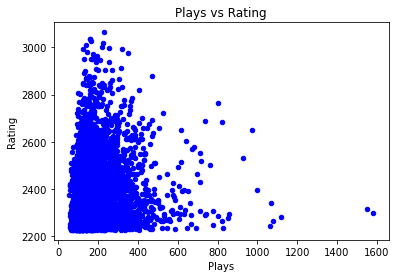

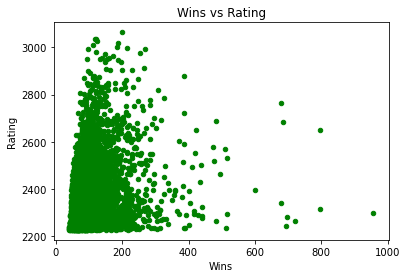

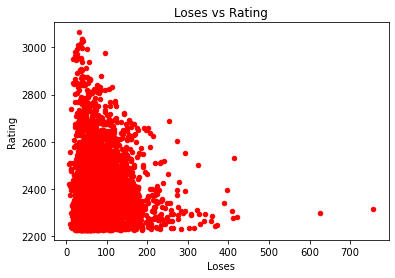

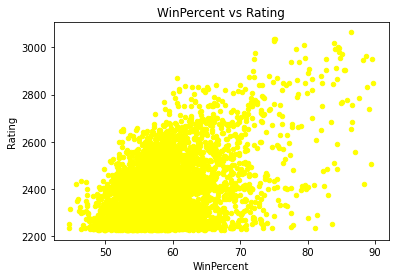

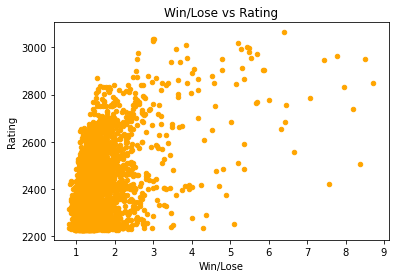

In [6]:
### Stat, Rating Correlation ###

df_player_stats.plot(kind='scatter', x='Plays', y='Rating', color='blue', title='Plays vs Rating')
df_player_stats.plot(kind='scatter', x='Wins', y='Rating', color='green', title='Wins vs Rating')
df_player_stats.plot(kind='scatter', x='Loses', y='Rating', color='red', title='Loses vs Rating')
df_player_stats.plot(kind='scatter', x='WinPercent', y='Rating', color='yellow', title='WinPercent vs Rating')
df_player_stats.plot(kind='scatter', x='Win/Lose', y='Rating', color='orange', title='Win/Lose vs Rating')
df_player_stats.corr(method='pearson')

In [7]:
df_rating=df_total[['Rank','Rating','GamerTag']]
df_rating.reset_index(inplace=True)
df_rating.drop('index', axis=1, inplace=True)

new = df_rating['Rank'].str.split(' ',expand = True)
#print(new)
df_rank=pd.DataFrame(new[3]) # US Rank #
df_rank.columns=['Rank']
df_rank

df_rank_rate = pd.concat([df_rank, df_rating['Rating']], axis=1)
df_rr=df_rank_rate.astype(float)
df_rr

df_player_rank=pd.concat([df_rank_rate, df_rating['GamerTag']], axis=1)
df_player_rank

df_LB=df_player_rank.astype({'Rank': 'int64', 'Rating':'int64','GamerTag':'string'},copy=False)
#print(df_LB.dtypes)

print('Displayed: Leaderboard Top 10')
df_LB.head(10)

Displayed: Leaderboard Top 10


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Rank,Rating,GamerTag
0,1,3064,Suspex
1,2,3036,Slipnslide
2,2,3036,Spanksv
3,4,3026,Vinnythepope
4,5,3019,Factszxy
5,6,3008,Manatears
6,7,3002,Pvpally
7,8,2998,Rip
8,9,2994,Camellita
9,10,2991,Kxitlyn


In [8]:
### Insert Player's GamerTag ###

GamerTag= 'Fiido' # Cap Sesnitive #

df_player=df_LB[df_LB['GamerTag'].str.contains(GamerTag)]
player_rating=df_player['Rating'].iloc[0]
player_rank=df_player['Rank'].iloc[0]
df_player_play_stats=df_player_stats[df_player_stats['GamerTag'].str.contains(GamerTag)]
player_wins=df_player_play_stats['Wins'].iloc[0]
player_loses=df_player_play_stats['Loses'].iloc[0]
player_win_perc=df_player_play_stats['WinPercent'].iloc[0]
print('Gamer: ' + str(GamerTag))
print('Player Rating: ' + str(player_rating))
print('Player Rank: ' + str(player_rank))
print('Player Wins: ' + str(player_wins))
print('Player Loses: ' + str(player_loses))
print('Player Win Percent: ' + str(player_win_perc.round(2)))

Gamer: Fiido
Player Rating: 2477
Player Rank: 978
Player Wins: 96
Player Loses: 53
Player Win Percent: 64.43


In [9]:
### Current Hero Rating Cutoff ###

start_link='https://www.arenamate.net/arena-rbg-title-cutoffs'
data = requests.get(start_link).text 
soup = BeautifulSoup(data,"html5lib")
archive_link = soup.find("div", attrs={"class": "dropdown"})
body=soup.find_all( 'strong')
#print(body)
#print(len(body))
str_value=str(body[24])
horde_rating=int(str_value[8:12])
horde_rating
print('Current Hero Rating Cutoff: ' + str(horde_rating))
print(' ')

### Did you make the cutoff? ###

if player_rating >= horde_rating:
    print(str(GamerTag) +' is Above the Cutoff')
    print('Winner Winner!')
else:
    print(str(GamerTag) +' is a loser, try harder next time.')

Current Hero Rating Cutoff: 2437
 
Fiido is Above the Cutoff
Winner Winner!


,Rank,Rating
count,4988.000000,4988.000000
mean,2501.052727,2388.296311
std,1446.602027,132.267039
min,1.000000,2227.000000
25%,1252.000000,2282.000000
50%,2507.000000,2371.000000
75%,3760.000000,2444.000000
max,4994.000000,3064.000000


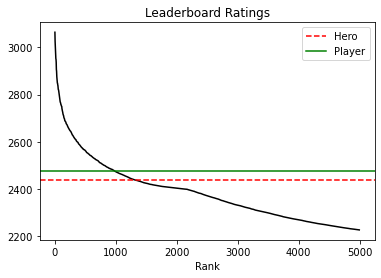

In [10]:
### Leaderboard Rank & Rating ###

df_LB.plot(x='Rank', y='Rating', color='black', title='Leaderboard Ratings')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_LB.describe()


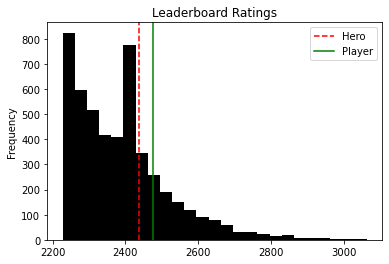

In [11]:
### Leaderboard Histogram ###

df_LB.Rating.plot(kind='hist', bins=25, color='black', title='Leaderboard Ratings')
hero=plt.axvline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axvline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])

In [12]:
### Rating Frequency ###

df_stat=df_rr.groupby('Rating').count()
df_count=df_stat.reset_index()
df_count.rename(columns={'Rank':'Count'}, inplace=True)
df_count

,Rating,Count
0,2227.0,24
1,2228.0,27
2,2229.0,25
3,2230.0,31
4,2231.0,25
...,...,...
558,3008.0,1
559,3019.0,1
560,3026.0,1
561,3036.0,2


,Rating,Count
count,563.000000,563.000000
mean,2525.577265,8.859680
std,192.119863,8.311968
min,2227.000000,1.000000
25%,2367.500000,2.000000
50%,2508.000000,6.000000
75%,2655.500000,13.000000
max,3064.000000,43.000000


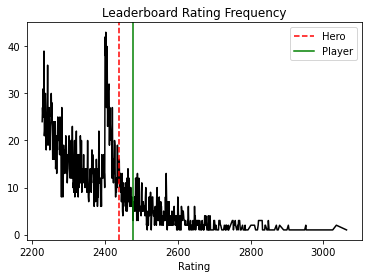

In [13]:
### Leaderboard Rating Fequency ###

df_count.plot(x='Rating', y='Count', color='black', title='Leaderboard Rating Frequency')
hero=plt.axvline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axvline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_count.describe()

In [14]:
### Hero Data ###

df_cutoff = df_rr.loc[df_rr['Rating'] >= horde_rating]
df_cutoff

,Rank,Rating
0,1.0,3064.0
1,2.0,3036.0
2,2.0,3036.0
3,4.0,3026.0
4,5.0,3019.0
...,...,...
1337,1338.0,2437.0
1338,1338.0,2437.0
1339,1338.0,2437.0
1340,1338.0,2437.0


In [15]:
### Below 2400 Rating ###

df_losers=df_rr.loc[df_rr['Rating'] < 2400]
df_losers

,Rank,Rating
2158,2169.0,2399.0
2159,2169.0,2399.0
2160,2169.0,2399.0
2161,2169.0,2399.0
2162,2169.0,2399.0
...,...,...
4983,4994.0,2227.0
4984,4994.0,2227.0
4985,4994.0,2227.0
4986,4994.0,2227.0


In [16]:
### Close to Cutoff ###

df_top=df_rr.drop(index=df_losers.index)
df_close=df_top.drop(index=df_cutoff.index)
df_close

,Rank,Rating
1342,1350.0,2436.0
1343,1350.0,2436.0
1344,1350.0,2436.0
1345,1350.0,2436.0
1346,1350.0,2436.0
...,...,...
2153,2127.0,2400.0
2154,2127.0,2400.0
2155,2127.0,2400.0
2156,2127.0,2400.0


In [17]:
df_close.describe()

,Rank,Rating
count,816.000000,816.000000
mean,1746.741422,2413.776961
std,231.618251,10.361645
min,1350.000000,2400.000000
25%,1551.000000,2405.000000
50%,1742.000000,2412.000000
75%,1942.000000,2421.000000
max,2127.000000,2436.000000


In [18]:
# Close to Cutoff Frequency ###

df_close_range=df_close.groupby('Rating').count().reset_index()
df_close_range.rename(columns={'Rank':'Count'}, inplace=True)
df_close_range

,Rating,Count
0,2400.0,42
1,2401.0,38
2,2402.0,43
3,2403.0,36
4,2404.0,27
5,2405.0,40
6,2406.0,35
7,2407.0,23
8,2408.0,29
9,2409.0,31


,Rating,Count
count,37.000000,37.000000
mean,2418.000000,22.054054
std,10.824355,10.099356
min,2400.000000,8.000000
25%,2409.000000,13.000000
50%,2418.000000,20.000000
75%,2427.000000,29.000000
max,2436.000000,43.000000


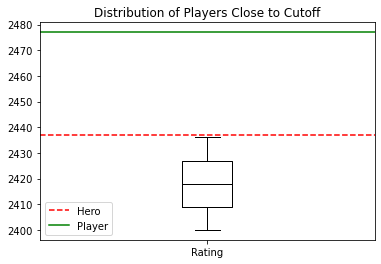

In [19]:
### Distribution of Players Below Cutoff, 2400 and Above ###

df_close_range.plot(kind='box',y='Rating', x='Count', color='black', title='Distribution of Players Close to Cutoff')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_close_range.describe()

In [20]:
# Players at Rating 2400 ###

df_2400=df_rr.loc[df_rr['Rating']==2400]
players_2400=df_2400.Rating.count()

print('Players at 2400: ' + str(players_2400))

Players at 2400: 42


In [21]:
### Hero Rating Frequency ###

df_top_divide=df_cutoff.groupby('Rating').count()
df_top_divide.reset_index(inplace=True)
df_top_divide

,Rating,Rank
0,2437.0,12
1,2438.0,14
2,2439.0,16
3,2440.0,10
4,2441.0,13
...,...,...
348,3008.0,1
349,3019.0,1
350,3026.0,1
351,3036.0,2


,Rating,Rank
count,353.000000,353.000000
mean,2641.033994,3.801700
std,144.563151,3.151532
min,2437.000000,1.000000
25%,2525.000000,1.000000
50%,2620.000000,3.000000
75%,2725.000000,5.000000
max,3064.000000,16.000000


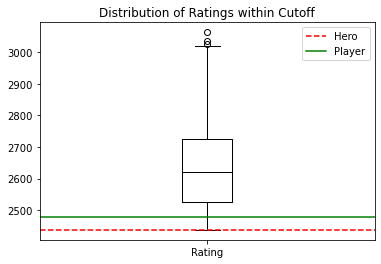

In [22]:
### Distribution of Hero Ratings ### 

df_top_divide.plot(kind='box' ,y='Rating', color='black', title='Distribution of Ratings within Cutoff')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_top_divide.describe()

Players in Hero: 1342
Total Players: 268400
 
Leaderboard Players Above You: 973
 
Leaderboard Players Below You: 4012
Hero Ranked Players Below You: 366


,Rank,Rating
count,4988.000000,4988.000000
mean,2501.052727,2388.296311
std,1446.602027,132.267039
min,1.000000,2227.000000
25%,1252.000000,2282.000000
50%,2507.000000,2371.000000
75%,3760.000000,2444.000000
max,4994.000000,3064.000000


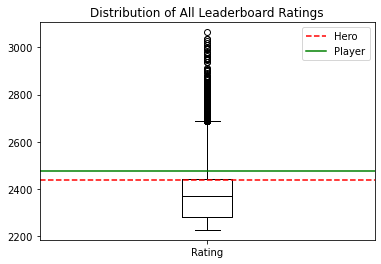

In [23]:
### Distribution of Leaderboard Ratings ###

df_rr.plot(kind='box', x='Rank',title='Distribution of All Leaderboard Ratings', color='black')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])

### Players you out rank within cutoff ###
df_bottoms=df_top_divide.loc[df_top_divide['Rating']<player_rating]
bottom_ranks=df_bottoms.Rank.sum()

### Leaderboard Players You Out Rank ###
df_outranked=df_rr.loc[df_rr['Rating']<player_rating]
df_bottom_divide=df_outranked.groupby('Rating').count()
df_bottom_divide.reset_index(inplace=True)
player_sum_below=df_bottom_divide.Rank.sum()

### Leaderboard Players Who Out Rank You ###
df_outrank=df_rr.loc[df_rr['Rating']>player_rating]
df_up_divide=df_outrank.groupby('Rating').count()
df_up_divide.reset_index(inplace=True)
player_sum_top=df_up_divide.Rank.sum()

### Players within Hero (top 0.5%) ###
heroes=len(df_cutoff)
pool=int(heroes*100/0.5)

print('Players in Hero: ' + str(heroes))
print('Total Players: ' + str(pool))
print(' ')
print('Leaderboard Players Above You: ' + str(player_sum_top))
print(' ')
print('Leaderboard Players Below You: ' + str(player_sum_below))
print('Hero Ranked Players Below You: ' + str(bottom_ranks))
df_rr.describe()

In [24]:
### Archived Hero Data from Previous Season ###

# Manually created hero season rating lists #

horde_season=['SL S1',
            'BfA S4','BfA S3','BfA S2','BfA S1',
            'Legion S7','Legion S6','Legion S5','Legion S4','Legion S4','Legion S2','Legion S1',
            'Warlords S3','Warlords S2','Warlords S1',
            'Season 15','Season 14',] 
horde_ratings=[horde_rating,
            2643,2392,2397,2681,
            2543,2530,2428,2449,2402,2500,2416,
            2304,2265,2155,
            2367,2200,] 

horde_season.reverse()
horde_ratings.reverse()

horde_data={'Season': horde_season, 'Rating': horde_ratings}

#print(horde_data)
df_horde=pd.DataFrame(horde_data)
df_horde

,Season,Rating
0,Season 14,2200
1,Season 15,2367
2,Warlords S1,2155
3,Warlords S2,2265
4,Warlords S3,2304
5,Legion S1,2416
6,Legion S2,2500
7,Legion S4,2402
8,Legion S4,2449
9,Legion S5,2428


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

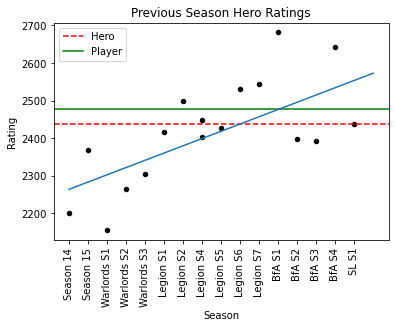

In [25]:
### Season Ratings Scatter plot & linear fit ###

y1=np.array(df_horde['Rating'])
x1=df_horde.index.values
x1,y1
m, b = np.polyfit(x1, y1, 1)


df_horde.plot(kind='scatter',x='Season', y='Rating', color='black',title='Previous Season Hero Ratings')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.plot(x1, m*x1 + b,)
plt.legend(handles=[hero, player])
plt.xticks(rotation = 90)

,Rating
count,17.000000
mean,2418.176471
std,139.907217
min,2155.000000
25%,2367.000000
50%,2416.000000
75%,2500.000000
max,2681.000000


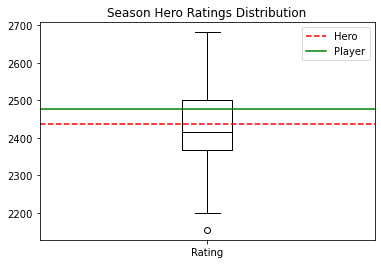

In [26]:
### Season Hero Ratings Distribution ###

df_horde.plot(kind='box', color='black',title='Season Hero Ratings Distribution')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_horde.describe()

,Fit,Rating
0,1,2572.784314
1,2,2496.545924
2,3,2463.402477
3,4,2481.142415
4,5,2478.994840
5,6,2472.472966
6,7,2476.646924
7,8,2445.056535
8,9,2439.118428


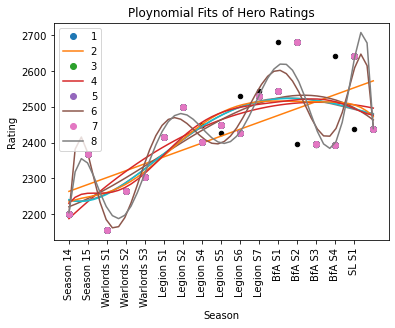

In [27]:
### Predicting Season End Hero Rating Cutoff ###

s16_predict=[]
fitcoed=[]
df_horde.plot(kind='scatter',x='Season', y='Rating', color='black', title= 'Ploynomial Fits of Hero Ratings')

for i in range(9):

    coefficients = np.polyfit(x1, y1, i+1)
    poly = np.poly1d(coefficients)

    new_x = np.linspace(x1[0], x1[-1])
    new_y = poly(new_x)
    plt.plot(x1, y1, "o", new_x, new_y, )
    plt.legend(fitcoed)
    plt.xticks(rotation = 90)
    predict=poly(16)
    s16_predict.append(predict)
    fitcoed.append(i+1)
    
horde_predict={'Fit': fitcoed , 'Rating': s16_predict}
df_horde_predict=pd.DataFrame(horde_predict)
df_horde_predict

All Powers Projected Season End Hero Rating: 2480
Standard Deviation: 38
 
Odd Power Projected Season End Hero Rating: 2486
Standard Deviation: 50
 
Even Power Projected Season End Hero Rating: 2473
Standard Deviation: 21
 
Best Prediction for Season End Hero of the Horde Cutoff: 2473 (Even Ploynomial Mean)


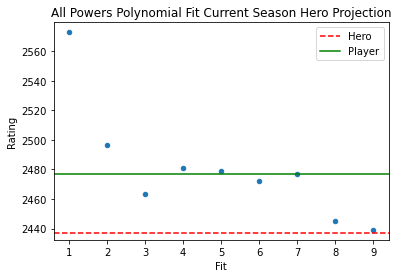

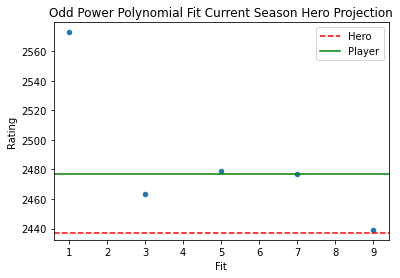

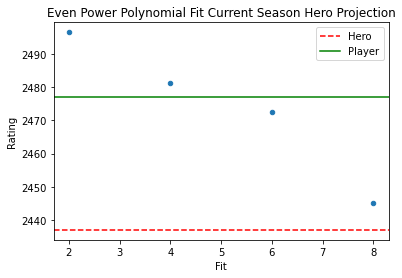

In [28]:
### Power Polynomial Fit Split Projectection ###

### All Powers Polynomial Fit Season End Hero Projection ###

df_horde_predict.describe()
df_horde_predict.plot(kind='scatter',x='Fit', y='Rating', title='All Powers Polynomial Fit Current Season Hero Projection')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])

print('All Powers Projected Season End Hero Rating: ' + str(int(df_horde_predict.Rating.mean())))
print('Standard Deviation: ' + str(int(df_horde_predict.Rating.std())))
print(' ')

### Odd Powers Polynomial Fit Season End Hero Projection ###

df_hp_odd_poly=df_horde_predict.drop([1,3,5,7])
df_hp_even_poly=df_horde_predict.drop([0,2,4,6,8])

df_hp_odd_poly.plot(kind='scatter',x='Fit', y='Rating', title='Odd Power Polynomial Fit Current Season Hero Projection')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_hp_odd_poly.describe()
print('Odd Power Projected Season End Hero Rating: ' + str(int(df_hp_odd_poly.Rating.mean())))
print('Standard Deviation: ' + str(int(df_hp_odd_poly.Rating.std())))
print(' ')

### Even Powers Polynomial Fit Season End Hero Projection ###

df_hp_even_poly.plot(kind='scatter',x='Fit', y='Rating', title='Even Power Polynomial Fit Current Season Hero Projection')
hero=plt.axhline(horde_rating, color='r', linestyle='dashed', label='Hero')
player=plt.axhline(player_rating, color='g', linestyle='-', label='Player')
plt.legend(handles=[hero, player])
df_hp_even_poly.describe()
print('Even Power Projected Season End Hero Rating: ' + str(int(df_hp_even_poly.Rating.mean())))
print('Standard Deviation: ' + str(int(df_hp_even_poly.Rating.std())))
print(' ')

### selecting best fit by smallest STD ###

best_mean=[int(df_horde_predict.Rating.mean()),int(df_hp_odd_poly.Rating.mean()),int(df_hp_even_poly.Rating.mean())]

best_std=[int(df_horde_predict.Rating.std()),int(df_hp_odd_poly.Rating.std()),int(df_hp_even_poly.Rating.std())]

poly_fits=['All','Odd','Even']

best_fit_table={'MeanRating': best_mean, 'STD': best_std, 'Fit': poly_fits}

df_best_fit=pd.DataFrame(best_fit_table)
df_best_fit.sort_values('STD', inplace=True)
df_best_fit.reset_index(inplace=True)
df_best_fit.drop('index', axis=1, inplace=True)
df_best_fit

print('Best Prediction for Season End Hero of the Horde Cutoff: ' + str(df_best_fit.MeanRating[0]) + ' (' + str(df_best_fit.Fit[0]) + ' Ploynomial Mean)')
